# Определение возраста покупателей

## Исследовательский анализ данных

Для начала извлечем все данные из папки. Импортируем все необходимые библиотеки в отдельной ячейке

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Всего у нас 7591 строка и нет пропусков. Все типы данных корректны, поэтому построим график распределения возрастов в выборке

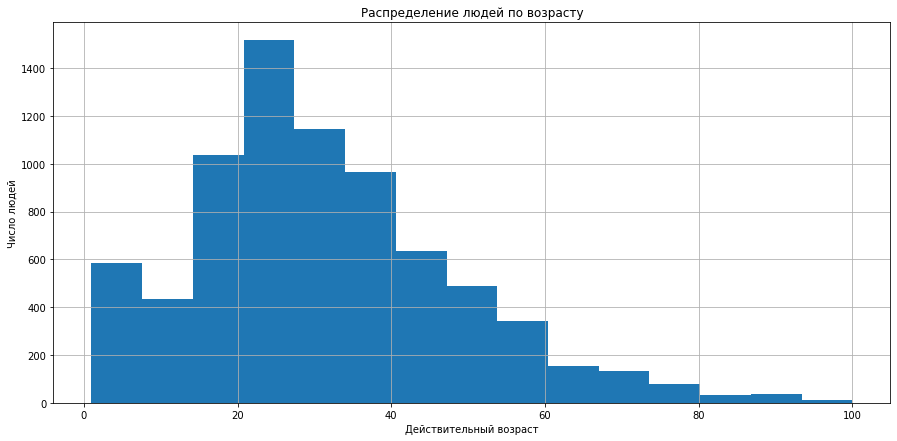

In [4]:
data['real_age'].hist(figsize=(15, 7), bins=15)
plt.xlabel('Действительный возраст')
plt.ylabel('Число людей')
plt.title('Распределение людей по возрасту')
plt.show()

In [9]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Видим нормальное распределение с небольшим смещением в левую сторону. Явно виден пик распределения. То есть распределение возраста имеет естественную структуру

Теперь загрузим все фотографии и рассмотрим 10-15 из них, чтобы посмотреть как они устроены

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(data, '/datasets/faces/final_files', x_col='file_name', 
    y_col='real_age', seed=12345, class_mode='raw')

Found 7591 validated image filenames.


In [6]:
images, labels = next(datagen_flow)
images[1].shape

(256, 256, 3)

Выберем 10 случайных фотографий из батча и посмотрим на их структуру

In [7]:
images = np.array(images)
random_indices = np.random.choice(images.shape[0], 10, replace=False)

Отобразим их

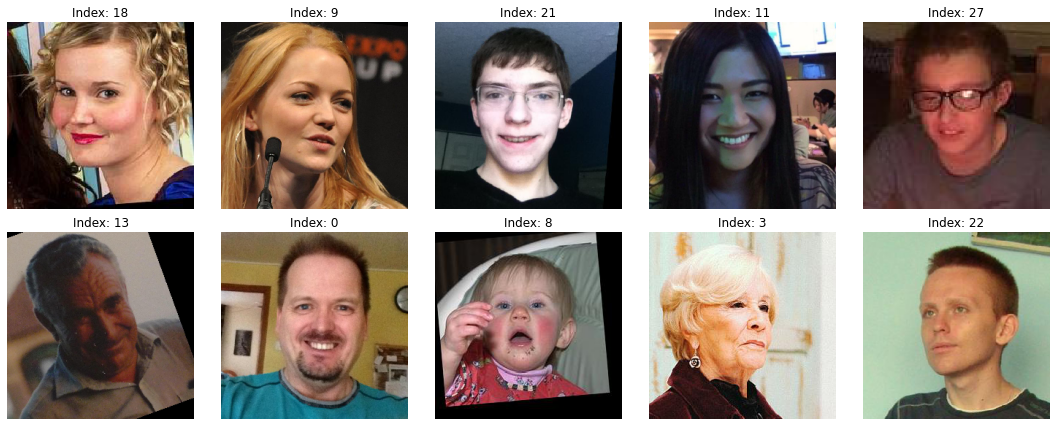

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img = images[idx]
    axes[i].imshow(img)
    axes[i].set_title(f'Index: {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

У нас есть RGB фотографии размером 256 на  256 пикселей. В одном батче хранится 32 фотографии

Сделаем выводы насчет исследовательского анализа данных. Во-первых, мы узнали размер фотографий и тип отображения, что поможет нам обучить модели. Во-вторых, мы выяснили, что возраст распределен нормально, то есть мы имеем естественную выборку и модель сможет хорошо справляться и с другими фотографиями людей

Мы загрузили датасет с фотографиями и получили, что в нем 7591 строка. Этого количесва достаточно для качественного обучения модели и хороших метрик

Минимальным возрастом в нашей выборке оказалось 1 год, а максимальным - 100 лет. Распределение возраста является нормальным со смещением в левую сторону, где и лежит реальный средний возраст по планете. Таким образом выборка соответствует естественным данным. Так же, можем наблюдать небольшие всплески на гистограмме в юбилейные годы, что слегка портит честность датасета

Фотографии являются цветными и почти на всех есть посторонние предметы на заднем плане. Так же, стоит заметить, что некоторые фотографии наклонены в ту или иную сторону на некоторый небольшой угол, в дальнейшем это можно решить аугментацией изображения

## Обучение модели

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):

  datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

  data = pd.read_csv(f'{path}/labels.csv')

  train_data= datagen.flow_from_dataframe(data, target_size=(256, 256), subset='training', directory=f'{path}/final_files', class_mode='raw', seed=12345, x_col='file_name', y_col='real_age')

  return train_data

def load_test(path):

  datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

  data = pd.read_csv(f'{path}/labels.csv')

  test_data = datagen.flow_from_dataframe(data, target_size=(256, 256), subset='validation', directory=f'{path}/final_files', class_mode='raw', seed=12345, x_col='file_name', y_col='real_age')

  return test_data

def create_model(input_shape):

    optimizer = Adam(learning_rate=0.0003)

    backbone = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    model = Sequential([
                          backbone,
                          GlobalAveragePooling2D(),
                          Dense(1, activation='relu')
                        ])

    model.compile(loss='mse',
              optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

  model.fit(  train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True  )

  return model

```

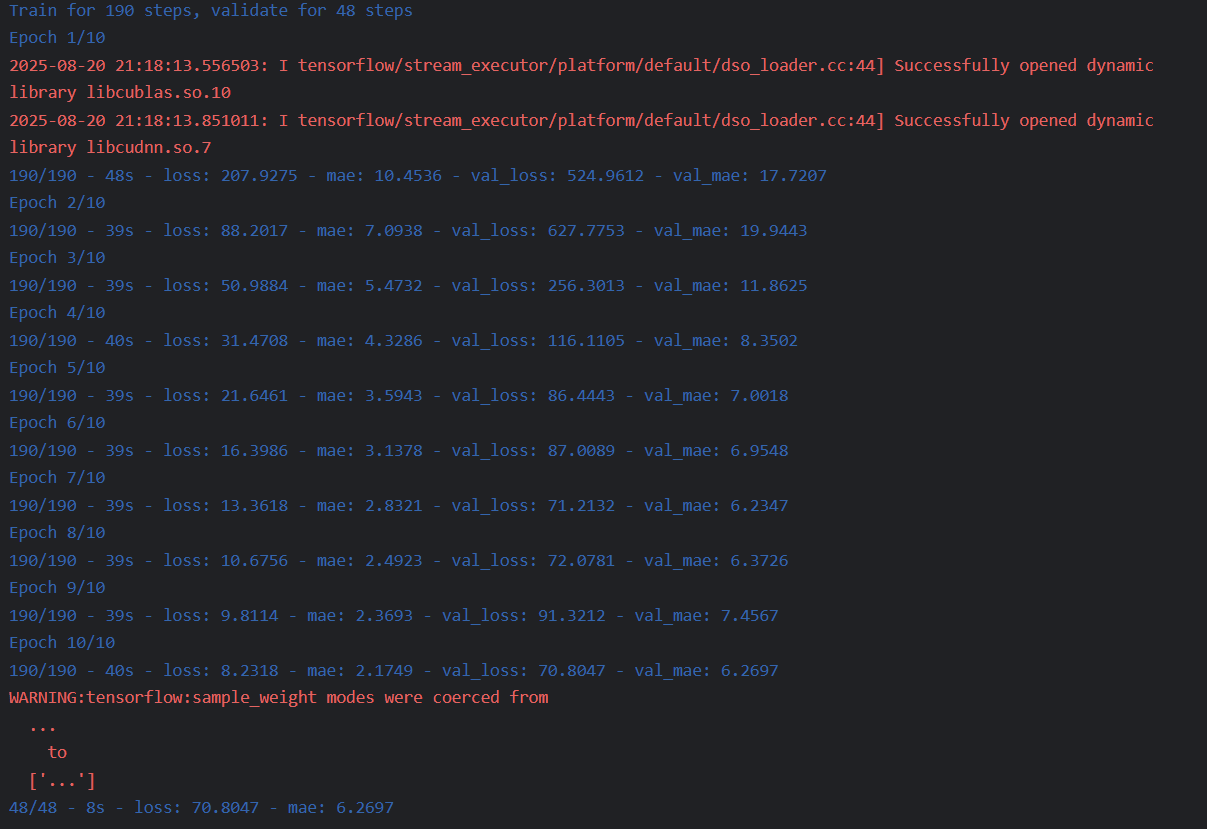

## Анализ обученной модели

Мы использовали для обучения модели стандартный ResNet50 с одним нейроном на выходе для предсказания возраста. Функция активации этого нейрона была выбрана relu для зануления отрицательных значений и линеаризации положительных. Модель обучалась на 10 эпохах и получила результат на валидационной выборке в виде MAE = 6.27, то есть модель ошибается на 6.27 года. Учитывая лучшую метрику в 5.4 года, наша модель отлично справилась с обучением и показала хорошие результаты на тестовых данных